In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from ultralytics import YOLO
from PIL import Image
from IPython.display import display


def cycle(j, i):
    """
    Your original segmenter call; returns:
      - polygons: list of (N×2) float arrays of the mask outlines
      - class_ids: 1D int array, same length as polygons
      - names:     dict mapping class_id → class_name
    """
    home     = os.path.expanduser("~")
    weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
    img_path = f"{home}/SubwaySurfers/train_screenshots/frame_03{j}{i}.jpg"

    img = Image.open(img_path)
    img = img.resize((600, 400))
    display(img)

    model   = YOLO(weights)
    results = model.predict(
        source=img_path, task="segment", conf=0.30, iou=0.45)[0]

    polygons1 = results.masks.xy
    class_ids1 = results.boxes.cls.cpu().numpy().astype(int)
    names1 = results.names
    
    return polygons1, \
           class_ids1, \
           names1, \
           img_path  # return img_path so we can reload

def highlight_rails_mask_only(
    img_path: str,
    rail_mask: np.ndarray,
    target_colors_rgb: list,
    tolerance: float = 30.0
):
    """
    Assumes `rail_mask` is a boolean (H, W) mask of rail regions.
    1) Finds pixels in `rail_mask` close in color to `target_colors_rgb`.
    2) Recolors those matches neon green.
    3) Skeletonizes + fits lines to structure.
    4) Displays result and returns final image.
    """
    # --- 1) Load original image ---
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    print(f"[DEBUG] Loaded image of shape: {img.shape}")

    assert rail_mask.shape == (h, w), f"rail_mask shape {rail_mask.shape} does not match image shape {(h, w)}"
    print(f"[DEBUG] rail_mask sum: {rail_mask.sum()}")

    plt.figure(); plt.imshow(rail_mask, cmap="gray"); plt.title("Rail Mask"); plt.axis("off"); plt.show()

    # --- 2) Colour‐match inside the rail mask ---
    targets_bgr = [(c[2], c[1], c[0]) for c in target_colors_rgb]
    img_f = img.astype(np.float32)
    color_mask = np.zeros((h, w), dtype=bool)

    for i, tb in enumerate(targets_bgr):
        tb_arr = np.array(tb, dtype=np.float32).reshape((1, 1, 3))
        dist = np.linalg.norm(img_f - tb_arr, axis=2)
        mask_this_color = dist <= tolerance
        color_mask |= mask_this_color
        print(f"[DEBUG] Color match {i}: BGR={tb}, matched pixels={mask_this_color.sum()}")

    plt.figure(); plt.imshow(color_mask, cmap="gray"); plt.title("Color Match Mask"); plt.axis("off"); plt.show()

    combined = rail_mask & color_mask
    print(f"[DEBUG] Combined mask sum: {combined.sum()}")

    plt.figure(); plt.imshow(combined, cmap="gray"); plt.title("Combined Mask"); plt.axis("off"); plt.show()

    # --- 3) Recolor matched pixels neon‐green in a copy ---
    result = img.copy()
    result[combined] = (0, 255, 0)
    print(f"[DEBUG] Recolored {combined.sum()} pixels to neon green")

    '''
    # --- 4) Skeletonize the combined mask ---
    skel_bool = skeletonize(combined)
    skel = (skel_bool.astype(np.uint8) * 255)
    print(f"[DEBUG] Skeleton non-zero pixels: {np.count_nonzero(skel)}")

    plt.figure(); plt.imshow(skel, cmap="gray"); plt.title("Skeleton"); plt.axis("off"); plt.show()

    # --- 5) Connected‐components & cv2.fitLine for each branch ---
    n_labels, labels = cv2.connectedComponents(skel)
    print(f"[DEBUG] Connected components found: {n_labels - 1}")

    for lab in range(1, n_labels):
        ys, xs = np.where(labels == lab)
        if len(xs) < 50:
            #print(f"[DEBUG] Skipping small component #{lab} (size: {len(xs)})")
            continue

        pts = np.column_stack((xs, ys)).astype(np.float32)
        vx, vy, x0, y0 = cv2.fitLine(pts, cv2.DIST_L2, 0, 0.01, 0.01).flatten()

        length = max(h, w) * 2
        pt1 = (int(x0 - vx * length), int(y0 - vy * length))
        pt2 = (int(x0 + vx * length), int(y0 + vy * length))
        cv2.line(result, pt1, pt2, (0, 255, 0), 2)
        #print(f"[DEBUG] Drew line for component #{lab} from {pt1} to {pt2}")

    # --- 6) Show final result ---
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Final Result with Rails Highlighted")
    plt.axis("off")
    plt.show()
    '''

    return result





In [11]:
def polygon_to_mask(poly, image_shape):
    """
    Converts an (N, 2) polygon to a binary mask of shape (H, W).
    """
    h, w = image_shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    pts = np.round(poly).astype(np.int32)
    cv2.fillPoly(mask, [pts], 1)
    return mask.astype(bool)


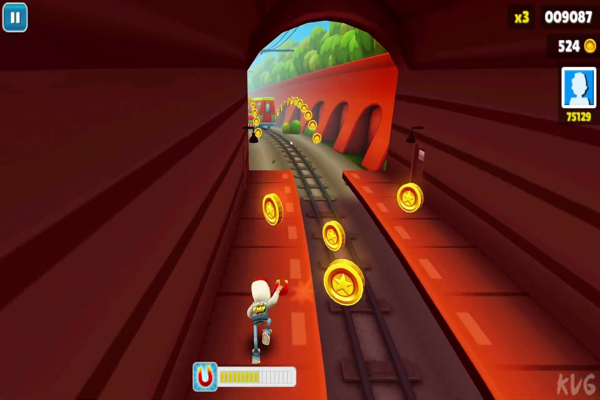


image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0342.jpg: 864x1504 1 ORANGETRAIN, 1 Rails, 2 Sidewalks, 399.9ms
Speed: 16.5ms preprocess, 399.9ms inference, 8.3ms postprocess per image at shape (1, 3, 864, 1504)
[DEBUG] Loaded image of shape: (1080, 1920, 3)
[DEBUG] rail_mask sum: 203378


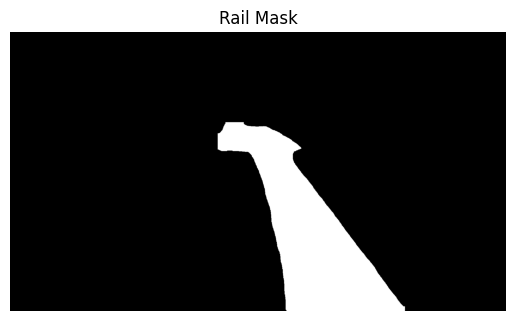

[DEBUG] Color match 0: BGR=(67, 104, 119), matched pixels=16769
[DEBUG] Color match 1: BGR=(45, 42, 81), matched pixels=126208


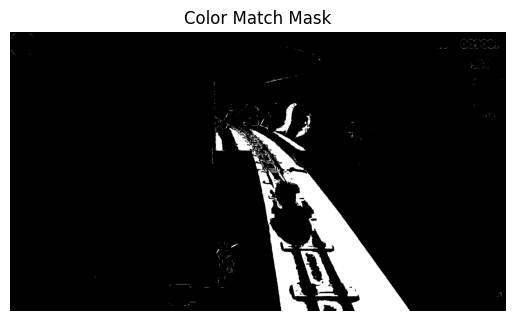

[DEBUG] Combined mask sum: 114664


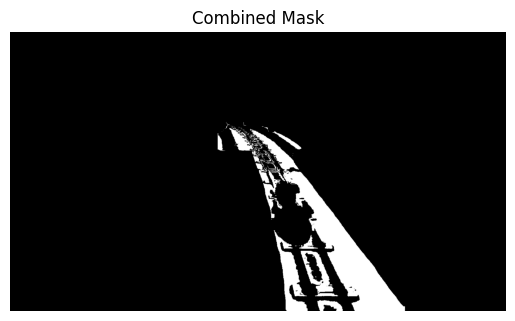

[DEBUG] Recolored 114664 pixels to neon green
Inference time: 736.71 ms


In [12]:

import time 

polygons, cls_ids, _, img_path = cycle(4,2)
rail_polys = [p for p, c in zip(polygons, cls_ids) if c == 9]

img = cv2.imread(img_path)
rail_mask = polygon_to_mask(rail_polys[0], img.shape)
start = time.time()
highlight_rails_mask_only(
    img_path=img_path,
    rail_mask=rail_mask,
    target_colors_rgb=[(119,104,67),(81,42,45)], #(76,75,71),(57,25,34), RAIL COLOURS
    tolerance=22
)
end = time.time()
print(f"Inference time: {(end - start) * 1000:.2f} ms")


In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

def cycle(j, i):
    """
    Your original segmenter call; returns:
      - polygons: list of (N×2) float arrays of the mask outlines
      - class_ids: 1D int array, same length as polygons
      - names:     dict mapping class_id → class_name
    """
    home     = os.path.expanduser("~")
    weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
    img_path = f"{home}/SubwaySurfers/train_screenshots/frame_03{j}{i}.jpg"

    img = Image.open(img_path)
    img = img.resize((600, 400))
    display(img)

    model   = YOLO(weights)
    results = model.predict(
        source=img_path, task="segment", conf=0.30, iou=0.45
    )[0]

    polygons1   = results.masks.xy
    class_ids1  = results.boxes.cls.cpu().numpy().astype(int)
    names1      = results.names
    
    return polygons1, class_ids1, names1, img_path

def highlight_rails_mask_only(
    img_path: str,
    rail_mask: np.ndarray,
    target_colors_rgb: list,
    tolerance: float = 30.0,
    min_region_size: int = 50,
    min_region_height: int = 1000  # ⬅️ NEW height threshold
):
    # --- 1) Load original image ---
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    print(f"[DEBUG] Loaded image of shape: {img.shape}")

    assert rail_mask.shape == (h, w), \
        f"rail_mask shape {rail_mask.shape} does not match image shape {(h, w)}"
    print(f"[DEBUG] rail_mask sum: {rail_mask.sum()}")

    plt.figure(); plt.imshow(rail_mask, cmap="gray")
    plt.title("Rail Mask"); plt.axis("off"); plt.show()

    # --- 2) Colour‐match inside the rail mask ---
    targets_bgr = [(c[2], c[1], c[0]) for c in target_colors_rgb]
    img_f       = img.astype(np.float32)
    color_mask  = np.zeros((h, w), dtype=bool)

    for i, tb in enumerate(targets_bgr):
        tb_arr = np.array(tb, dtype=np.float32).reshape((1, 1, 3))
        dist   = np.linalg.norm(img_f - tb_arr, axis=2)
        mask_this_color = dist <= tolerance
        color_mask |= mask_this_color
        print(f"[DEBUG] Color match {i}: BGR={tb}, matched pixels={mask_this_color.sum()}")

    plt.figure(); plt.imshow(color_mask, cmap="gray")
    plt.title("Color Match Mask"); plt.axis("off"); plt.show()

    # --- 3) Combine masks ---
    combined = rail_mask & color_mask
    raw_sum  = combined.sum()
    print(f"[DEBUG] Raw combined mask sum: {raw_sum}")

    # --- 4) Drop small and short neon‐green regions ---
    comp_uint8 = combined.astype(np.uint8)
    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(comp_uint8, connectivity=8)
    filtered = np.zeros_like(combined)

    for lbl in range(1, n_labels):
        area   = stats[lbl, cv2.CC_STAT_AREA]
        height = stats[lbl, cv2.CC_STAT_HEIGHT]
        if area >= min_region_size and height >= min_region_height:
            filtered[labels == lbl] = True

    combined = filtered
    filt_sum = combined.sum()
    print(f"[DEBUG] Filtered combined mask sum (area ≥{min_region_size}, height ≥{min_region_height}): {filt_sum}")

    plt.figure(); plt.imshow(combined, cmap="gray")
    plt.title("Filtered Combined Mask"); plt.axis("off"); plt.show()

    # --- 5) Recolor matched pixels neon‐green in a copy ---
    result = img.copy()
    result[combined] = (0, 255, 0)
    print(f"[DEBUG] Recolored {combined.sum()} pixels to neon green")

    # --- 6) Show final result ---
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Final Result with Rails Highlighted")
    plt.axis("off"); plt.show()

    return result


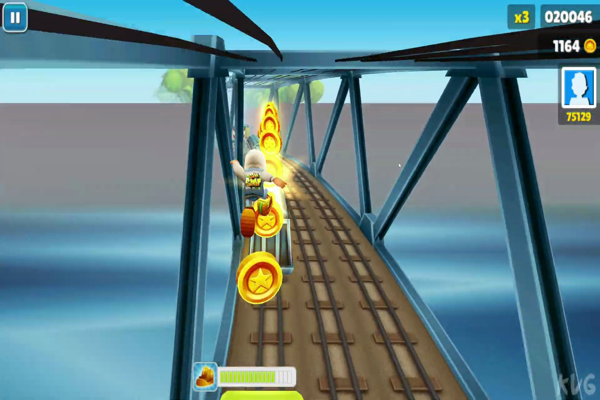


image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0383.jpg: 864x1504 1 GREYTRAIN, 1 Rails, 318.3ms
Speed: 9.8ms preprocess, 318.3ms inference, 5.0ms postprocess per image at shape (1, 3, 864, 1504)
[DEBUG] Loaded image of shape: (1080, 1920, 3)
[DEBUG] rail_mask sum: 259171


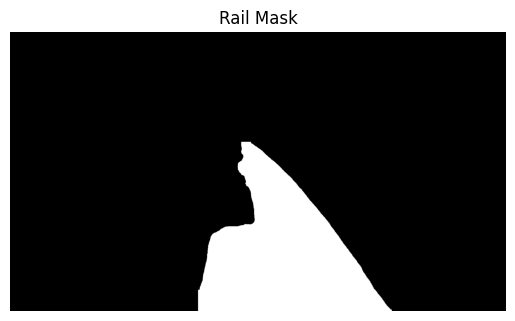

[DEBUG] Color match 0: BGR=(67, 104, 119), matched pixels=110561
[DEBUG] Color match 1: BGR=(45, 42, 81), matched pixels=8610


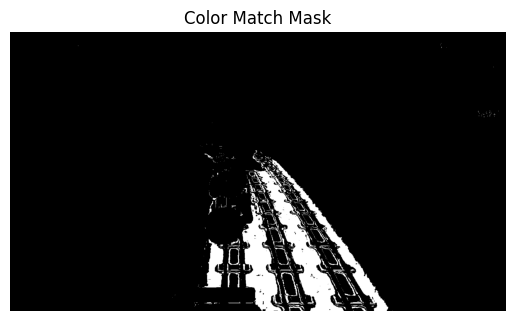

[DEBUG] Raw combined mask sum: 115886
[DEBUG] Filtered combined mask sum (area ≥50, height ≥150): 98318


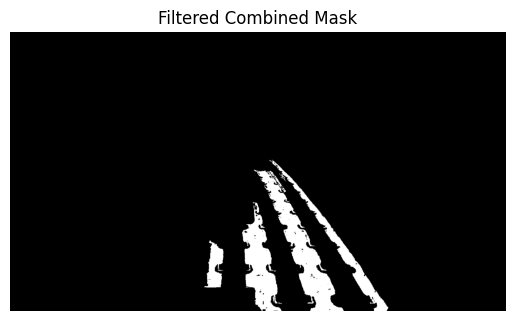

[DEBUG] Recolored 98318 pixels to neon green


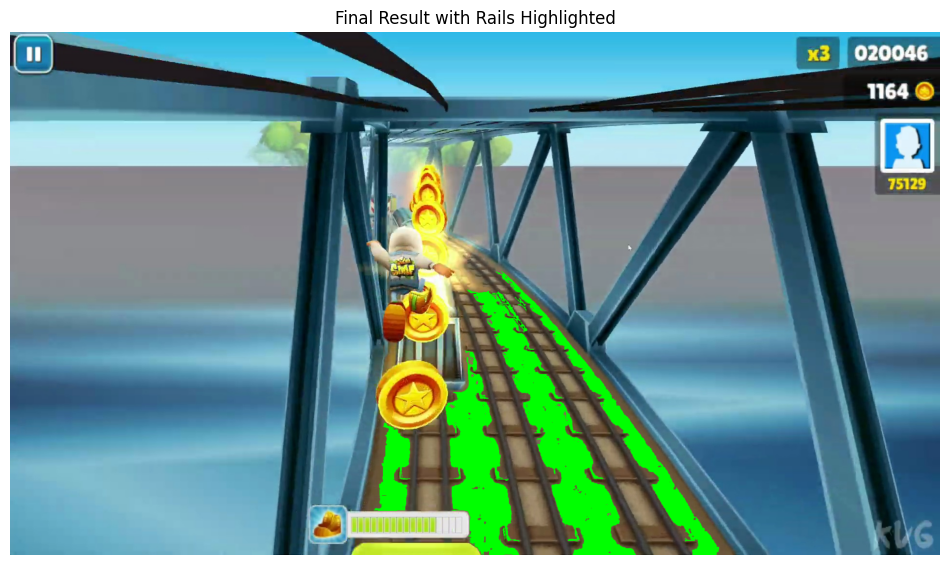

array([[[178, 161, 112],
        [178, 161, 112],
        [178, 161, 110],
        ...,
        [233, 188,  47],
        [233, 188,  47],
        [233, 188,  47]],

       [[178, 161, 112],
        [178, 161, 110],
        [178, 161, 110],
        ...,
        [233, 188,  47],
        [233, 188,  47],
        [233, 188,  47]],

       [[180, 161, 110],
        [180, 162, 109],
        [178, 162, 109],
        ...,
        [233, 189,  46],
        [233, 189,  46],
        [233, 189,  46]],

       ...,

       [[180, 157,  89],
        [177, 154,  86],
        [179, 157,  86],
        ...,
        [142, 102,  43],
        [142, 102,  43],
        [142, 102,  43]],

       [[173, 152,  84],
        [168, 147,  79],
        [173, 153,  82],
        ...,
        [144, 104,  45],
        [144, 104,  45],
        [144, 104,  45]],

       [[168, 147,  79],
        [161, 140,  72],
        [169, 149,  78],
        ...,
        [146, 106,  47],
        [146, 106,  47],
        [146, 106,  47]]

In [16]:
# 1) Run your cycle() to get polygons, class IDs, and path
polygons, cls_ids, _, img_path = cycle(8, 3)

# 2) Filter for rail polygons
rail_polys = [p for p, c in zip(polygons, cls_ids) if c == 9]

# 3) Rasterize the first rail polygon into a boolean mask
img = cv2.imread(img_path)
rail_mask = polygon_to_mask(rail_polys[0], img.shape)  # now rail_mask is (H, W) bool array

highlight_rails_mask_only(
    img_path,
    rail_mask=rail_mask,
    target_colors_rgb=[(119,104,67),(81,42,45)],
    tolerance=20,
    min_region_size=50,
    min_region_height=150
)



In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

def cyclev3(j, i):
    """
    Your original segmenter call; returns:
      - polygons: list of (N×2) float arrays of the mask outlines
      - class_ids: 1D int array, same length as polygons
      - names:     dict mapping class_id → class_name
    """
    home     = os.path.expanduser("~")
    weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
    img_path = f"{home}/SubwaySurfers/train_screenshots/frame_03{j}{i}.jpg"

    img = Image.open(img_path)
    img = img.resize((600, 400))
    display(img)

    model   = YOLO(weights)
    results = model.predict(
        source=img_path, task="segment", conf=0.30, iou=0.45
    )[0]

    polygons1   = results.masks.xy
    class_ids1  = results.boxes.cls.cpu().numpy().astype(int)
    names1      = results.names
    
    return polygons1, class_ids1, names1, img_path

def highlight_rails_mask_only(
    img_path: str,
    rail_mask: np.ndarray,
    target_colors_rgb: list,
    tolerance: float = 30.0,
    min_region_size: int = 50,
    min_region_height: int = 1000  # ⬅️ NEW height threshold
):
    # --- 1) Load original image ---
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    #print(f"[DEBUG] Loaded image of shape: {img.shape}")

    assert rail_mask.shape == (h, w), \
        f"rail_mask shape {rail_mask.shape} does not match image shape {(h, w)}"
    #print(f"[DEBUG] rail_mask sum: {rail_mask.sum()}")

    # plt.figure(); plt.imshow(rail_mask, cmap="gray")
    # plt.title("Rail Mask"); plt.axis("off"); plt.show()

    # --- 2) Colour‐match inside the rail mask ---
    targets_bgr = [(c[2], c[1], c[0]) for c in target_colors_rgb]
    img_f       = img.astype(np.float32)
    color_mask  = np.zeros((h, w), dtype=bool)

    for i, tb in enumerate(targets_bgr):
        tb_arr = np.array(tb, dtype=np.float32).reshape((1, 1, 3))
        dist   = np.linalg.norm(img_f - tb_arr, axis=2)
        mask_this_color = dist <= tolerance
        color_mask |= mask_this_color
        #print(f"[DEBUG] Color match {i}: BGR={tb}, matched pixels={mask_this_color.sum()}")

    # plt.figure(); plt.imshow(color_mask, cmap="gray")
    # plt.title("Color Match Mask"); plt.axis("off"); plt.show()

    # --- 3) Combine masks ---
    combined = rail_mask & color_mask
    raw_sum  = combined.sum()
    #print(f"[DEBUG] Raw combined mask sum: {raw_sum}")

    # --- 4) Drop small and short neon‐green regions ---
    comp_uint8 = combined.astype(np.uint8)
    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(comp_uint8, connectivity=8)
    filtered = np.zeros_like(combined)

    for lbl in range(1, n_labels):
        area   = stats[lbl, cv2.CC_STAT_AREA]
        height = stats[lbl, cv2.CC_STAT_HEIGHT]
        if area >= min_region_size and height >= min_region_height:
            filtered[labels == lbl] = True

    combined = filtered
    filt_sum = combined.sum()
    #print(f"[DEBUG] Filtered combined mask sum (area ≥{min_region_size}, height ≥{min_region_height}): {filt_sum}")

    plt.figure(); plt.imshow(combined, cmap="gray")
    plt.title("Filtered Combined Mask"); plt.axis("off"); plt.show()
    return 


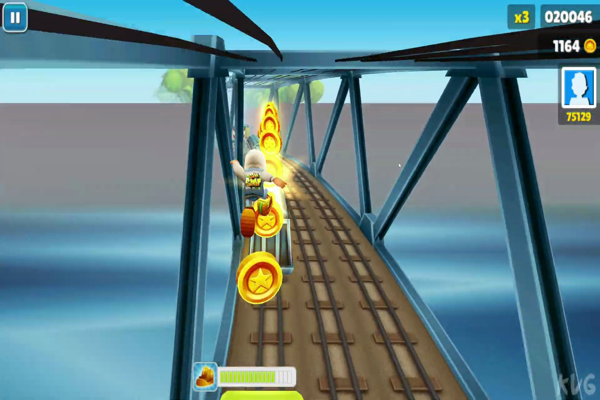


image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0383.jpg: 864x1504 1 GREYTRAIN, 1 Rails, 316.0ms
Speed: 10.2ms preprocess, 316.0ms inference, 6.3ms postprocess per image at shape (1, 3, 864, 1504)


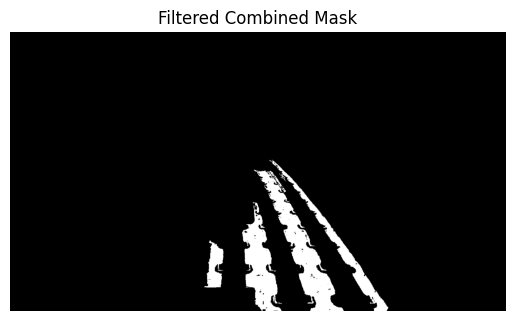

In [27]:
# 1) Run your cycle() to get polygons, class IDs, and path
polygons, cls_ids, _, img_path = cyclev3(8, 3)

# 2) Filter for rail polygons
rail_polys = [p for p, c in zip(polygons, cls_ids) if c == 9]

# 3) Rasterize the first rail polygon into a boolean mask
img = cv2.imread(img_path)
rail_mask = polygon_to_mask(rail_polys[0], img.shape)  # now rail_mask is (H, W) bool array

highlight_rails_mask_only(
    img_path,
    rail_mask=rail_mask,
    target_colors_rgb=[(119,104,67),(81,42,45)],
    tolerance=20,
    min_region_size=50,
    min_region_height=150
)



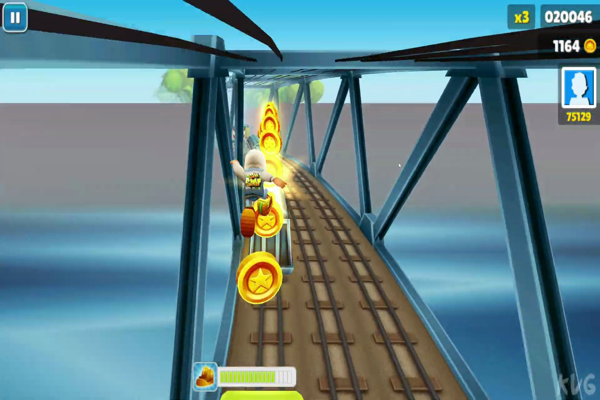


image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0383.jpg: 864x1504 1 GREYTRAIN, 1 Rails, 292.1ms
Speed: 8.7ms preprocess, 292.1ms inference, 5.7ms postprocess per image at shape (1, 3, 864, 1504)
[Timing] Inference (cyclev3): 0.436s
[Timing] Rail‐polygon filter: 0.000s
[Timing] Polygon→mask rasterization: 0.009s
[Timing] Color matching: 0.091s
[Timing] Component filtering: 0.016s


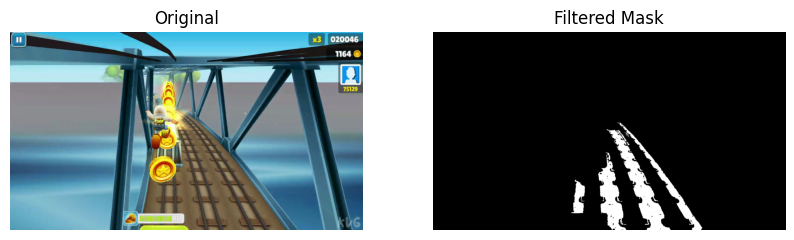

[Timing] Total highlight call: 0.414s


In [40]:
import time
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

# instrumented cyclev3 wrapper
t0 = time.time()
polygons, cls_ids, names, img_path = cyclev3(8, 3)
t1 = time.time()
print(f"[Timing] Inference (cyclev3): {t1 - t0:.3f}s")

# filter for rails
t0 = time.time()
rail_polys = [p for p, c in zip(polygons, cls_ids) if c == 9]
t1 = time.time()
print(f"[Timing] Rail‐polygon filter: {t1 - t0:.3f}s")

# rasterize first rail
t0 = time.time()
img = cv2.imread(img_path)
rail_mask = polygon_to_mask(rail_polys[0], img.shape)
t1 = time.time()
print(f"[Timing] Polygon→mask rasterization: {t1 - t0:.3f}s")

# now instrument the highlight function itself
def highlight_rails_mask_only_timed(
    img_path, rail_mask, target_colors_rgb, tolerance=30.0,
    min_region_size=50, min_region_height=1000
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # color‐matching
    t0 = time.time()
    targets_bgr = [(c[2], c[1], c[0]) for c in target_colors_rgb]
    img_f = img.astype(np.float32)
    color_mask = np.zeros((h, w), dtype=bool)
    for tb in targets_bgr:
        tb_arr = np.array(tb, dtype=np.float32).reshape((1,1,3))
        dist = np.linalg.norm(img_f - tb_arr, axis=2)
        color_mask |= (dist <= tolerance)
    t1 = time.time()
    print(f"[Timing] Color matching: {t1 - t0:.3f}s")

    # component filtering
    t0 = time.time()
    combined = rail_mask & color_mask
    comp_uint8 = combined.astype(np.uint8)
    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(comp_uint8, 8)
    filtered = np.zeros_like(combined)
    for lbl in range(1, n_labels):
        area   = stats[lbl, cv2.CC_STAT_AREA]
        height = stats[lbl, cv2.CC_STAT_HEIGHT]
        if area >= min_region_size and height >= min_region_height:
            filtered[labels == lbl] = True
    t1 = time.time()
    print(f"[Timing] Component filtering: {t1 - t0:.3f}s")

    # display
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(filtered, cmap='gray'); plt.axis('off'); plt.title("Filtered Mask")
    plt.show()

    return filtered

# run the timed version
t0 = time.time()
filtered_mask = highlight_rails_mask_only_timed(
    img_path,
    rail_mask=rail_mask,
    target_colors_rgb=[(119,104,67),(81,42,45)],
    tolerance=20,
    min_region_size=50,
    min_region_height=150
)
t1 = time.time()
print(f"[Timing] Total highlight call: {t1 - t0:.3f}s")


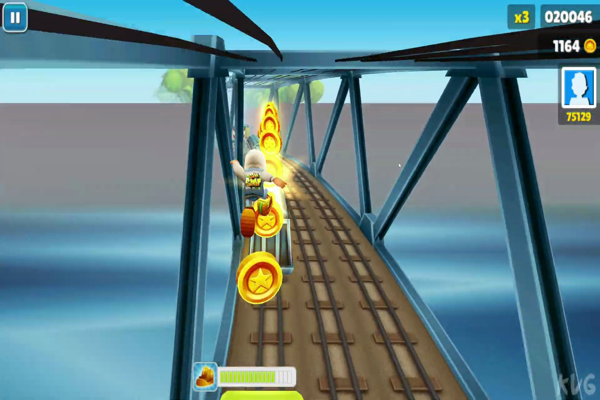


image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0383.jpg: 864x1504 1 GREYTRAIN, 1 Rails, 422.7ms
Speed: 17.4ms preprocess, 422.7ms inference, 6.1ms postprocess per image at shape (1, 3, 864, 1504)
[Timing] Inference (cyclev3): 0.697s
[Timing] Rail‐polygon filter: 0.000s
[Timing] Polygon→mask rasterization: 0.011s
[Timing] Color matching: 0.106s
[Timing] Component filtering: 0.046s


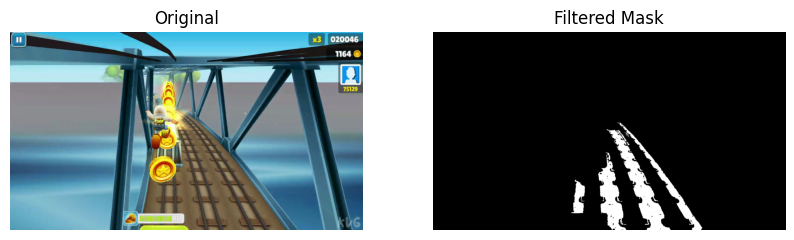

[Timing] Total highlight call: 0.487s


In [45]:
import time
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

# instrumented cyclev3 wrapper
t0 = time.time()
polygons, cls_ids, names, img_path = cyclev3(8, 3)
t1 = time.time()
print(f"[Timing] Inference (cyclev3): {t1 - t0:.3f}s")

# filter for rails
t0 = time.time()
rail_polys = [p for p, c in zip(polygons, cls_ids) if c == 9]
t1 = time.time()
print(f"[Timing] Rail‐polygon filter: {t1 - t0:.3f}s")

# rasterize first rail
t0 = time.time()
img = cv2.imread(img_path)
rail_mask = polygon_to_mask(rail_polys[0], img.shape)
t1 = time.time()
print(f"[Timing] Polygon→mask rasterization: {t1 - t0:.3f}s")

# now instrument the highlight function itself
def highlight_fast(img, rail_mask, colors_bgr, tol, min_area, min_h):
    # 1) C‐level color match
    lb1, ub1 = np.subtract(colors_bgr[0], tol), np.add(colors_bgr[0], tol)
    lb2, ub2 = np.subtract(colors_bgr[1], tol), np.add(colors_bgr[1], tol)
    m1 = cv2.inRange(img, lb1, ub1)
    m2 = cv2.inRange(img, lb2, ub2)
    color_mask = cv2.bitwise_or(m1, m2).astype(bool)

    # 2) combine + morphological
    comb = (rail_mask & color_mask).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, min_h))
    opened = cv2.morphologyEx(comb, cv2.MORPH_OPEN, kernel)

    # 3) contour filter
    filtered = np.zeros_like(opened)
    cts, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in cts:
        x,y,w,h = cv2.boundingRect(cnt)
        if cv2.contourArea(cnt)>=min_area and h>=min_h:
            cv2.drawContours(filtered, [cnt], -1, 1, cv2.FILLED)

    return filtered


# run the timed version
t0 = time.time()
filtered_mask = highlight_rails_mask_only_timed(
    img_path,
    rail_mask=rail_mask,
    target_colors_rgb=[(119,104,67),(81,42,45)],
    tolerance=20,
    min_region_size=50,
    min_region_height=150
)
t1 = time.time()
print(f"[Timing] Total highlight call: {t1 - t0:.3f}s")
